# Exploring Twitter during the pandemic

The notebook showcases applications of our work. It uses results of the data processing pipeline in  <span style="color:green">scripts/trends_pipeline.py</span>, consisting of the following steps :

**prepare_df (~2h30)**
- Clean tweets and create a new DataFrame (df) in Tweets_piped with cols (id, lang, country_code, text, hashtags)
- populate hashtags column as string with separator
- Compute word counts
- Build text file for Word2Vec
- Save newly built df, save and return counts_per_word
    
**Word2Vec (1h30 for 150d)**
* Train a Word2Vec model and save it
    
**find_topics (10h)**
* Generate topics : dict(id, list(hashtag))
* Generate higher topics : dict(id, list(topic_id))
* Save in 2 different dicts in the same file
    
**label_sentiments(~10h)**
* Create new sentiment column in Tweets_piped
* Generate sentiment labels and put them in df
* Save df

**Topic Trends (5 min.)**
* Compute trend based on each df in Tweets_piped
* save it as dict(topic_nb, list(int))


We can list *5* ways to explore a Twitter dataset using our work.

* <span style="color:red">Similarity lookup</span> : Given a hashtag/word, discover similar ones using Word2vec embeddings

* <span style="color:red">Topics Browsing</span>   : Read topics to get a broad overview, use them to filter tweets
* <span style="color:red">Sentiment polling</span> : Find most concerning topics and get sentiment for an event/policy in particular
* <span style="color:red">Correlation study</span> : Discover interesting correlations with regard to topics trends
* <span style="color:red">Timeline creation</span> : Automatically create a timeline based on trends of topics 


We go through each of them in the following cells.

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os
import pickle as pkl
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

/home/hartley/.local/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Similarity lookup
Given a hashtag/word, we discover similar ones using Word2vec embeddings

In [2]:
#model_path = '/mlo-container-scratch/massemin/twitter_covid_insights_v3/insights_All/word2vec_300d.model'
model_path = '/mlo-container-scratch/hartley/twitter_covid_insights/insights_All/word2vec_300d.model'
w2v_model = Word2Vec.load(model_path) 

Looking for the climate-related hashtags

In [4]:
w2v_model.wv.most_similar('#blacklivesmater')

[('#minneapolisriots', 0.6388505101203918),
 ('#justiceforgeorgefloyd', 0.5742713212966919),
 ('#georgefloyd', 0.5314555764198303),
 ('#nojusticenopeace', 0.5314106941223145),
 ('#blacklivesmattter', 0.5164079070091248),
 ('#blackoutday', 0.5122958421707153),
 ('#georgefloydfuneral', 0.5091673135757446),
 ('#blacklivesmatters', 0.5030421018600464),
 ('#breonnataylor', 0.5024369359016418),
 ('#justiceforgeorgeflyod', 0.5012010931968689)]

Or looking for words related to Trump (words were stemmed for a more accurate clustering)

In [5]:
w2v_model.wv.most_similar('trump')

[('presid', 0.7198337912559509),
 ('biden', 0.6892713308334351),
 ('american', 0.6701903939247131),
 ('potu', 0.6588947176933289),
 ('republican', 0.6286548972129822),
 ('gop', 0.6239457726478577),
 ('djt', 0.6212260723114014),
 ('lie', 0.564298152923584),
 ('wh', 0.5612642765045166),
 ('democrat', 0.5562548041343689)]

## Topics Browsing

We say that hashtags whose embeddings form a clusters are part of the same topic. Topics are useful for getting a broad overview of what's being discussed, they can be understood as lexical fields. The cell below randomly picks 10 topics and displays the corresponding hashtags

In [3]:
topics_path = '/mlo-container-scratch/hartley/twitter_covid_insights/insights_All/topics.pkl'
topics = pkl.load(open(topics_path, 'rb'))

print(f'There are {len(topics[0])} topics and {len(topics[1])} meta-topics.')

topics_indices = np.random.choice(range(len(topics[0])), size=10)
for idx in topics_indices :
    print('\n' + str(idx))
    print(topics[0][idx])

There are 858 topics and 10 meta-topics.

336
['#jin' '#seokjin' '#btsjin' '#방탄소년단진' '#진' '#김석진' '#석진' '#방탄진']

364
['#uae' '#dubai' '#egypt' '#bahrain' '#somalia' '#abudhabi' '#sudan'
 '#burkinafaso' '#niger' '#somali']

4
['#muscle' '#masturbate' '#bodybuilder' '#edging' '#muscleworship'
 '#poppers' '#monstercock' '#bator' '#gooner' '#roidpig' '#popperbate'
 '#nevertoobig' '#uncutcock' '#popperbator' '#batelife']

493
['#sooraraipottru' '#suriya' '#ந' '#agaramcovidedufund' '#arm'
 '#justiceforjayarajandbennicks' '#eiadraft2020' '#sooraraipottruonprime'
 '#aruvaa' '#ponmagalvandhal' '#sfcwelfareworks' '#happybirthdaysuriya'
 '#neetsuicide' '#sudhakongara' '#sathankulam']

118
['#furry' '#furryart' '#furryfandom' '#fursuit' '#furries' '#furryartist']

827
['#burytheracistgoponnov3' '#burythegoponnov3'
 '#makeamericatrumplessagain' '#helpexplodethebluevote'
 '#rememberhisfailuretoprotectusonnov3' '#presidentepicfail'
 '#president1termtoomany' '#presidenttestingisoverrated'
 '#presidentu

meta-topics group similar topics together, below is an interesting example grouping together flat-earthers, Qanon, 5g and fake news.

In [7]:
meta_topics = topics[1]
idx = 3

print(f'There are {len(topics[1])} meta-topics.')
print(f'meta_topics[{idx}] = {meta_topics[idx]}')
print('Associated hashtags :')
for t_idx in meta_topics[idx] :
    print('\n' + t_idx)
    print(topics[0][int(t_idx)])
    #hash_string = '-'.join(topics[0][int(t_idx)])
    #print(f'\t{int(t_idx):4} : {hash_string}')

There are 10 meta-topics.
meta_topics[3] = ['33' '43' '48' '58' '59' '72' '92' '100' '115' '147' '148' '155' '157'
 '159' '170' '172' '173' '185' '186' '201' '269' '303' '304' '309' '310'
 '313' '337' '338' '340' '402' '442' '477' '488' '528']
Associated hashtags :

33
['#karnatakafightscorona' '#kalingatv' '#punefightscorona' '#harshvardhan'
 '#containmentzones' '#opoyi' '#mohfw' '#jodhpur' '#tnieupdatesoncovid19'
 '#punefightscovid19' '#delhigovt' '#coronacases' '#pcmc' '#bsf'
 '#durgapuja' '#belagavi' '#delhigovernment' '#navratri' '#durgapuja2020'
 '#section144' '#kurnool' '#containmentzone' '#drharshvardhan' '#guntur'
 '#mumbaikars' '#dussehra' '#pimprichinchwad' '#srikakulam' '#mohfw_india'
 '#dussehra2020' '#navaratri' '#sonipat' '#indiamaximum' '#marathwada'
 '#teenmaarnews' '#gurunanakdevji' '#gurupurab']

43
['#mumbaipolice' '#mumbairains' '#arnab' '#sushantsinghrajputdeathcase'
 '#kangnaranaut' '#mumbairain']

48
['#bjpfailsindia' '#bjpfailscoronafight' '#bjpdestroysdemocrac

Finally, given a word, one can check the topics that are related to it

In [8]:
def related_topics(word) :
    print(f"Topics related to the word \033[1m{word}\033[0m :\n")
    seen = set()
    for t in topics[0] :
        tags = topics[0][t]
        for w in tags :
            if word in w and t not in seen:
                    print(f'\n{t}')
                    print(tags)
                    seen.add(t)
    if len(seen) == 0 :
        print('No topic found')
        
related_topics('vaccine')

Topics related to the word vaccine :


74
['#vaccine' '#vaccines' '#covidvaccine' '#coronavirusvaccine'
 '#vaccination' '#coronavaccine' '#pfizer' '#covid19vaccine' '#bigpharma'
 '#moderna' '#astrazeneca' '#oxford' '#oxforduniversity' '#novavax'
 '#seruminstitute' '#dcgi' '#covishield' '#seruminstituteofindia'
 '#zyduscadila' '#adarpoonawalla']

85
['#flu' '#sars_cov_2' '#vaccineswork' '#influenza' '#flushot' '#crispr'
 '#mutation']

513
['#cuba' '#cubaporlasalud' '#cubaessalud' '#cuban' '#cubasalva'
 '#cubacoopera' '#dezurdateam' '#unblockcuba' '#havana' '#blockade'
 '#cubavsbloqueo' '#theblockadekills' '#soberana01' '#cubaeseducacion'
 '#end60yrsoldblockade' '#stoplyingaboutcuba' '#vamospormas'
 '#cienciacubana' '#notohelmsburton' '#soberana' '#orgullosodesercubano'
 '#vaccinework']

694
['#covid19tests' '#covid19cyprus' '#cypruscoronavirus'
 '#coronaviruscyprus' '#cyprusairports' '#cypruspolice'
 '#cypruslockdownmeasures' '#covid19vaccinecyprus']

769
['#instanews' '#newsdesk' '#tod

## Sentiment survey

Using sentiment labels, we can find topics expressing the most concern, or the more optimistic ones. We use topic trends to derive the sentiment polarity. As a reminder, trends is a 2-tuple of *dict(topic_idx, list(int))* where the first dict is for topics and the second for meta-topics. Each int is the number of tweets being twitted in that topic, for a specific day.For each topic x, we add two keys 'Pos-x' and 'Neg-x' to account for polarized tweets. 

In [9]:
trends_path = '/mlo-container-scratch/massemin/twitter_covid_insights_v3/insights_All/trends_raw.pkl'
trends = pkl.load(open(trends_path, 'rb'))

In [10]:
polarities = []
for t in topics[0] :
    polarity = trends[0][f'Pos-{t}'].sum() / trends[0][str(t)].sum()
    polarities.append((t, polarity))
    
polarities = sorted(polarities, key=lambda x : x[1])

We study the distribution of sentiment among topics

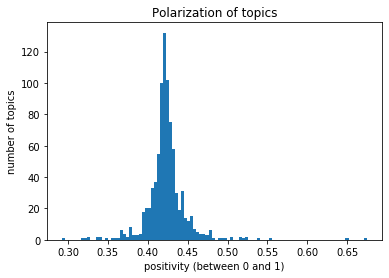

In [11]:
plt.hist(np.array(polarities)[:, 1], bins=100)
plt.title('Polarization of topics')
plt.xlabel('positivity (between 0 and 1)')
plt.ylabel('number of topics')
plt.show()

It seems that most topics are considered rather neutral, if not slightly negative,  by our classifier. A reason might be that diferent sentiments, both positive and negative, are carried in tweets from the same topic. We check what the most polarized topics are.

In [12]:
nb_to_print=20
print(f"\033[1mThese are the {nb_to_print} most negative topics\033[0m :")
for p in polarities[:nb_to_print] :
    print(f'\n{p[0]}, ratio={p[1]:.3f}')
    print(topics[0][p[0]])
    
print(f"\n\n\n\033[1mThese are the {nb_to_print} most positive topics\033[0m :")
for p in polarities[-nb_to_print:][::-1] :
    print(f'\n{p[0]}, ratio={p[1]:.3f}')
    print(topics[0][p[0]])

These are the 20 most negative topics :

319, ratio=0.293
['#storytime' '#freaky' '#freakythreads' '#threads' '#freaks'
 '#storytimethreads' '#freakythread' '#threadstorytime' '#freakystorytime'
 '#storytimethread' '#freakystorytimes' '#freakyfreaky' '#imaginary']

358, ratio=0.319
['#sinovac' '#qingdao' '#cansino' '#sinopharm' '#coronavac' '#sadarpranam'
 '#cn19cvd' '#cansinobiologics' '#chenwei' '#cnbg' '#chinainaction']

390, ratio=0.322
['#n95mask' '#kn95' '#respirator' '#surgicalmasks' '#goggles' '#boomwow'
 '#childrensmasks']

499, ratio=0.326
['#war' '#terrorism' '#isis' '#terrorist' '#terrorists' '#terror'
 '#warcrimes' '#alqaeda' '#islamicterrorism' '#punishment' '#isil'
 '#islamicextremism']

656, ratio=0.327
['#wiunion' '#wisgop' '#waukesha' '#wi01' '#wi05' '#wi08' '#wipol' '#wi06'
 '#oconomowoc']

811, ratio=0.335
['#shitler' '#makeamericaunitedagain' '#vetsforscience' '#ftrumps'
 '#fucktrumpsshit' '#defeatbytweet']

557, ratio=0.338
['#dtix' '#boci' '#simta' '#airtrti' '#t

One can also get an evolution of the sentiment carried in a given topic over time. Below is an example for vaccines

topic : 
['#pr' '#publicrelations' '#crisiscommunications' '#crisiscomms' '#prtips'
 '#covidpr']


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


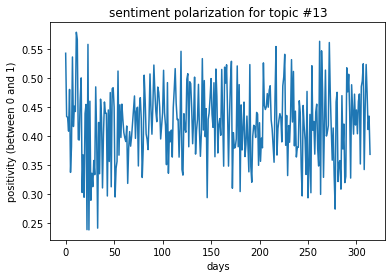

In [13]:
topic = 13

print('topic : ')
print(topics[0][topic])
plt.plot((trends[0][f'Pos-{str(topic)}'] / trends[0][str(topic)])[115:])
plt.xlabel('days')
plt.ylabel('positivity (between 0 and 1)')
plt.title(f'sentiment polarization for topic #{topic}')
plt.show()

## Correlation Study
We correlate trends together and with other interesting features, used in the what-if project. We start with cross-correlation. We apply a gaussian filter to adjust the scale at which we want to compute correlations, a bigger $\sigma$ corresponding to a higher scale less sensible to small variations. You can see below the effect of adjusting $\sigma$ on a topic trend.  

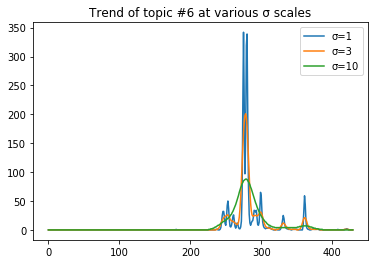

In [14]:
from scipy.ndimage import gaussian_filter1d
topic='6'
plt.plot(gaussian_filter1d(trends[0][topic], sigma=1), label='\u03C3=1')
plt.plot(gaussian_filter1d(trends[0][topic], sigma=3), label='\u03C3=3')
plt.plot(gaussian_filter1d(trends[0][topic], sigma=10), label='\u03C3=10')
plt.title(f'Trend of topic #{topic} at various \u03C3 scales')
plt.legend()
plt.show()

We move on to correlations between topics, It is useful to discover their relationships with each other. We choose $\sigma=2$.

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hartley/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/hartley/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


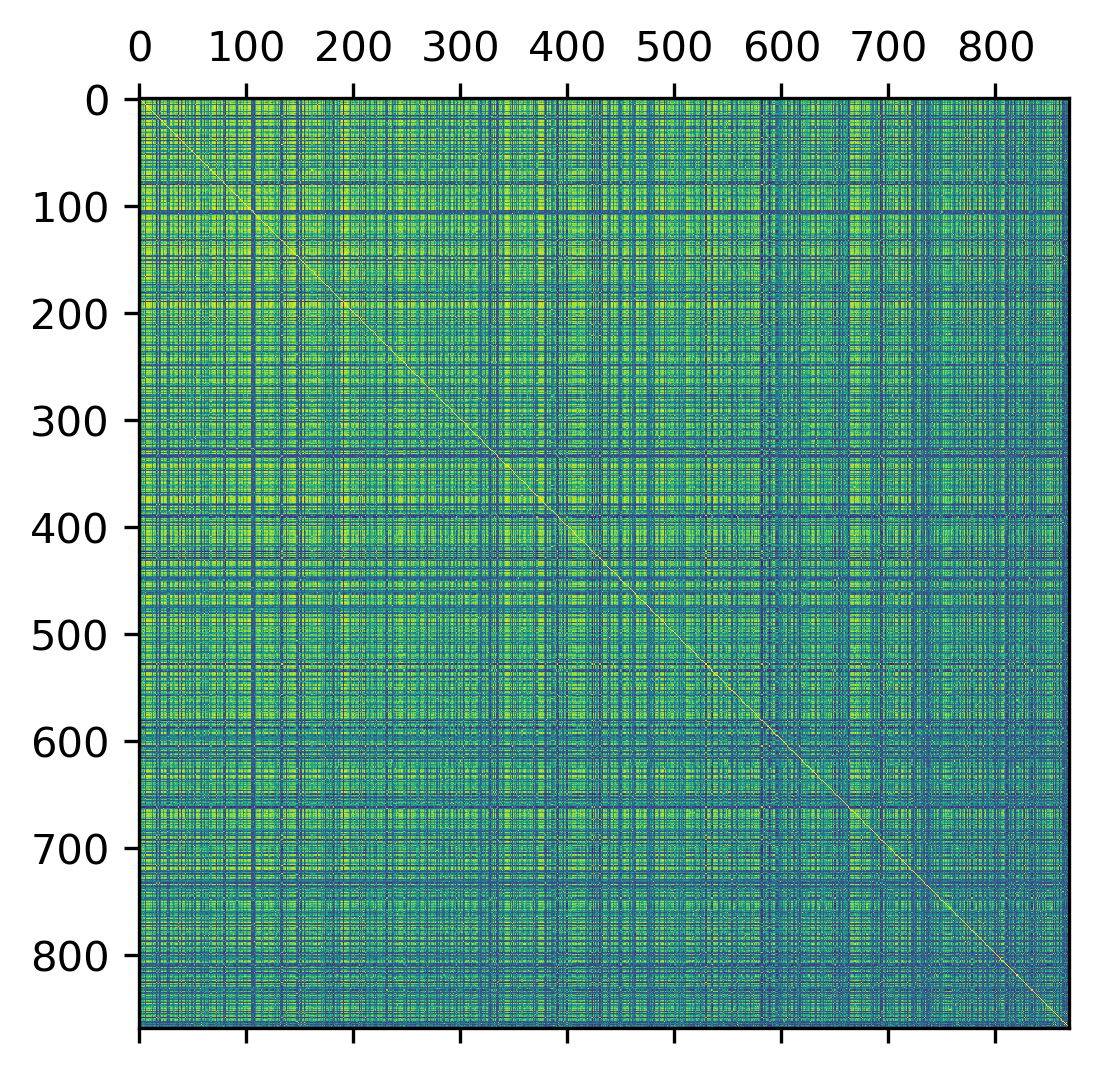

In [16]:
import sys 
sys.path.insert(1,'../scripts')
from hash_utils import counts_cross_corr
from scipy.ndimage import gaussian_filter1d

no_sent = dict([(str(k), gaussian_filter1d(v, sigma=2)) for k, v in trends[0].items() if '-' not in k])
corrs, cross_corr = counts_cross_corr(no_sent, nb_corrs=100)

From the matrix, we can clearly see that some topics are closely correlated. We investigate good and bad scores 

In [17]:
print(f"\033[1mPositive correlations :\033[0m")
for c in corrs[:10] :
    print(f'\n\n{c[0]} - {c[1]} : {c[2]:.3}')
    print(topics[0][int(c[0])])
    print(topics[0][int(c[1])])
    
print(f"\n\n\n\033[1mNegative correlations :\033[0m")
for c in corrs[-10:] :
    print(f'\n\n{c[0]} - {c[1]} : {c[2]:.3}')
    print(topics[0][int(c[0])])
    print(topics[0][int(c[1])])

Positive correlations :


302 - 771 : 0.993
['#soap' '#ukgifthour' '#ukgiftam' '#soaps' '#palmoilfree'
 '#veganfriendly' '#artisansoap']
['#safecity' '#ilovetaguig' '#psca' '#ppic3' '#ministryofpakistan'
 '#healthycity']


771 - 788 : 0.992
['#safecity' '#ilovetaguig' '#psca' '#ppic3' '#ministryofpakistan'
 '#healthycity']
['#uhaul' '#truevalue' '#loweshomeimprovement' '#gouhaul' '#acehardwares'
 '#northerntool' '#shoulderdolly']


102 - 104 : 0.99
['#nudist' '#naturism' '#nudism' '#normalisingnaturism'
 '#thegoddessofjiggles' '#naturist' '#diosa' '#fkk' '#covidbush2020'
 '#goj' '#teamnaturist' '#normalizenudity']
['#trump' '#usa' '#donaldtrump' '#america' '#gop' '#election2020' '#biden'
 '#democrats' '#potus' '#joebiden' '#americans' '#republicans'
 '#whitehouse' '#democrat' '#american' '#obama' '#pence' '#2020election'
 '#elections2020' '#presidenttrump' '#dems' '#dnc' '#impeachment'
 '#2020elections' '#buildthewall' '#trumps' '#hillaryclinton'
 '#donaldtrumpjr' '#electionfraud' '#fi

We can spot many spurious correlations but a small expertise allow to filter them out. After filtering, we still find correlations that make sense, mostly between semantically-related topics. The negative correlations seem to be mostly spurious.

Next, we look at correlations between topics trends and data from the What-if project, for US only because most of our tweets come from the US. More specifically, we ran correlation with weather, mobility and epidemiological data. The cell below uses results generated in  <span style="color:green">notebooks/Correlations.ipynb</span>.

In [18]:
# Loading correlations
wi_corr_path = '/mlo-container-scratch/massemin/twitter_covid_insights_v3/insights_All/corr_scores.pkl'
wi_corr = pkl.load(open(wi_corr_path, 'rb'))

print(f'There are {len(wi_corr)} correlations computed.')
print('Columns are : corr|p-value|topic_idx|feature')

wi_corr[:5]

There are 14399 correlations computed.
Columns are : corr|p-value|topic_idx|feature


[(-0.980324455692648, 6.403154160030102e-07, 'Pol-692', 'test'),
 (-0.9776769870584323, 2.1318546146488048e-16, 'Pol-19', 'test'),
 (-0.970838172847866, 8.33844358405021e-09, 'Pol-792', 'test'),
 (-0.9611808859260003, 1.206764685315716e-08, 'Pol-831', 'death'),
 (-0.9380345055741268, 2.3842582675097766e-07, 'Pol-801', 'death')]

We focus on strongest correlations and look at results

In [19]:
nb_corrs = 30
print(f"\033[1mPositive correlations :\033[0m")
for c in wi_corr[-nb_corrs:][::-1] :
    if '-' not in c[2] :
        print(f'\n\n{c[2]} - {c[3]} : {c[0]:.3}')
        print(topics[0][int(c[2])])
    
print(f"\n\n\n\033[1mNegative correlations :\033[0m")
for c in wi_corr[:nb_corrs] :
    if '-' not in c[2] :
        print(f'\n\n{c[2]} - {c[3]} : {c[0]:.3}')
        print(topics[0][int(c[2])])

Positive correlations :


678 - FeelsLikeC : 0.871
['#legalnews' '#indiannews' '#latestlaws' '#beehub' '#beehubapp'
 '#stayinsightful' '#gaininsights' '#beehubnews' '#beehubnewsbytes']


678 - mintempC : 0.87
['#legalnews' '#indiannews' '#latestlaws' '#beehub' '#beehubapp'
 '#stayinsightful' '#gaininsights' '#beehubnews' '#beehubnewsbytes']


678 - maxtempC : 0.865
['#legalnews' '#indiannews' '#latestlaws' '#beehub' '#beehubapp'
 '#stayinsightful' '#gaininsights' '#beehubnews' '#beehubnewsbytes']


287 - mintempC : 0.841
['#noplan' '#trumpunfit' '#removetrumpenablers' '#noexcuse'
 '#americansvote' '#removegopenablers' '#nonationalcovidstrategy'
 '#trumppenceunfit']


135 - mintempC : 0.84
['#artecontemporaneo' '#dibujos' '#artista' '#pintor' '#galeria'
 '#artistadelasemana' '#plastico']


135 - FeelsLikeC : 0.839
['#artecontemporaneo' '#dibujos' '#artista' '#pintor' '#galeria'
 '#artistadelasemana' '#plastico']



Negative correlations :


342 - transit : -0.933
['#kingcounty' '#pierce

Those correlations seem to be more accurate. High stringency (more constraints) and low transit are associated to indoor activities and support to the nhs, as well as concern about economy and health.


We can be more precise in our search and look for topics positively correlated to transit to see what they cover :

In [20]:
transit_sorted = sorted([w for w in wi_corr if w[3]=='transit'], key=lambda x : x[0])

In [21]:
print(f"\n\n\n\033[1mStrongest positive correlations with transit in the US :\033[0m")
for c in transit_sorted[:20] :
    if '-' not in c[2] :
        print(f'\n\n{c[2]} - {c[3]} : {c[0]:.3}')
        print(topics[0][int(c[2])])




Strongest positive correlations with transit in the US :


342 - transit : -0.933
['#kingcounty' '#piercecounty' '#snohomishcounty' '#bentoncounty'
 '#franklincounty' '#yakimacounty']


136 - transit : -0.926
['#mentalhealth' '#anxiety' '#wellbeing' '#mentalhealthmatters' '#stress'
 '#mentalhealthawareness' '#mentalhealthawarenessmonth'
 '#mentalhealthmonth']


103 - transit : -0.925
['#sextape' '#brittanya' '#piercings' '#brittanya187' '#bigspanishdick'
 '#juicypussy' '#eatingpussy' '#brittanyarazavi' '#sextapeleaked'
 '#brittanyasextape']


41 - transit : -0.908
['#windenergy' '#solarpanels' '#windmills' '#geothermalenergy'
 '#waveenergy' '#steamenergy' '#wavegenerators']


330 - transit : -0.907
['#brentwood' '#concord' '#contracostacounty' '#antioch' '#walnutcreek'
 '#sanpablo' '#pittsburg' '#oakley']


415 - transit : -0.895
['#disabilityawareness' '#wheelchair' '#peoplewithdisabilities'
 '#wheelchairlife' '#wheelchairgirl' '#wheelchairdontcare']


167 - transit : -0.894
['#ast

Surprisingly, we mostly find topics about banking and trading.

## Timeline Creation
We can classify trends to detect events (i.e peaks in trends), and explore those events or arrange them in a timeline.
The cell below uses results generated in  <span style="color:green">notebooks/Timeline.ipynb</span>.

In [29]:
events_path = '/mlo-container-scratch/massemin/twitter_covid_insights_v3/insights_All/events.pkl'
events = pkl.load(open(events_path, 'rb'))

print(f'There are {len(events)} events.')
print('The table has the following columns : topic_id|day_nb|peak_date')
events[:5]

There are 148 events.
The table has the following columns : topic_id|day_nb|peak_date


[('190', 0, '2020-01-24'),
 ('16', 2, '2020-01-26'),
 ('429', 2, '2020-01-26'),
 ('717', 2, '2020-01-26'),
 ('19', 5, '2020-01-29')]

We pick 10 events at random and look at them in detail



 event_id=96 - topic_id=462 - peak_date=2020-07-07 
['#happybirthdaydhoni' '#mahendrasinghdhoni' '#thaladhoni'
 '#msdhonibirthday' '#mahi' '#vikrambatra']


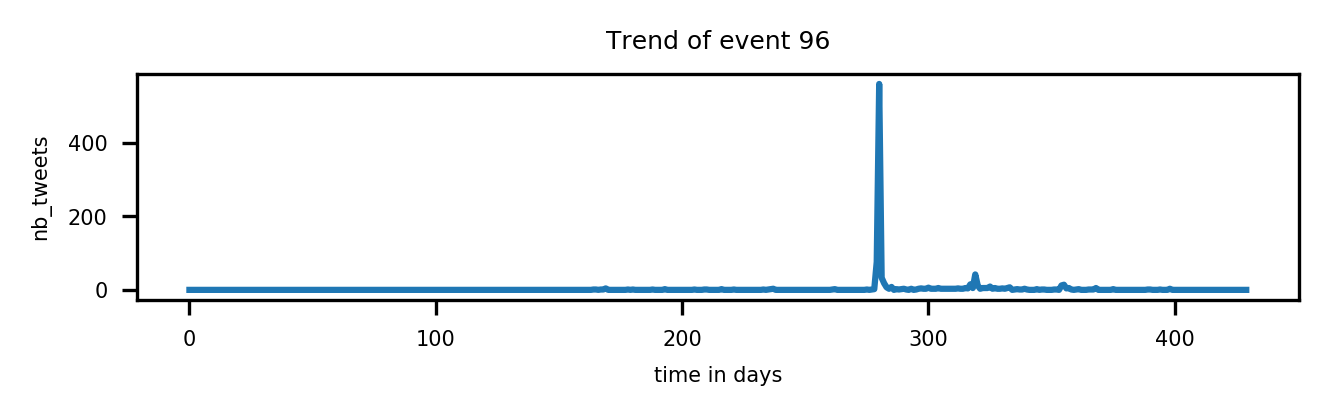



 event_id=64 - topic_id=382 - peak_date=2020-05-24 
['#pop' '#comiccon' '#sdcc' '#webradio' '#nevers' '#onlineradiobox'
 '#radioking' '#radioline' '#radiofr' '#radioexpert' '#mytuner'
 '#radioenligne' '#orangeradios' '#funko' '#sdcc2020' '#funkopop'
 '#sandiegocomiccon' '#pops']


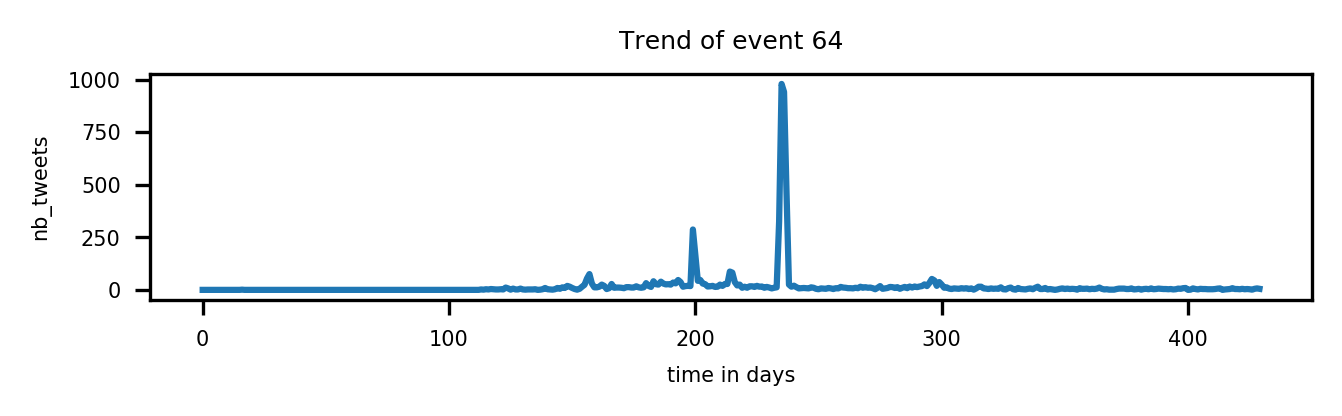



 event_id=0 - topic_id=190 - peak_date=2020-01-24 
['#avionpresidencial' '#coronacapitalgdl' '#redamlo'
 '#paronacional24feb2020' '#preolimpico2020' '#redunidossomosuntsunami'
 '#lopezelcancerdemexico']


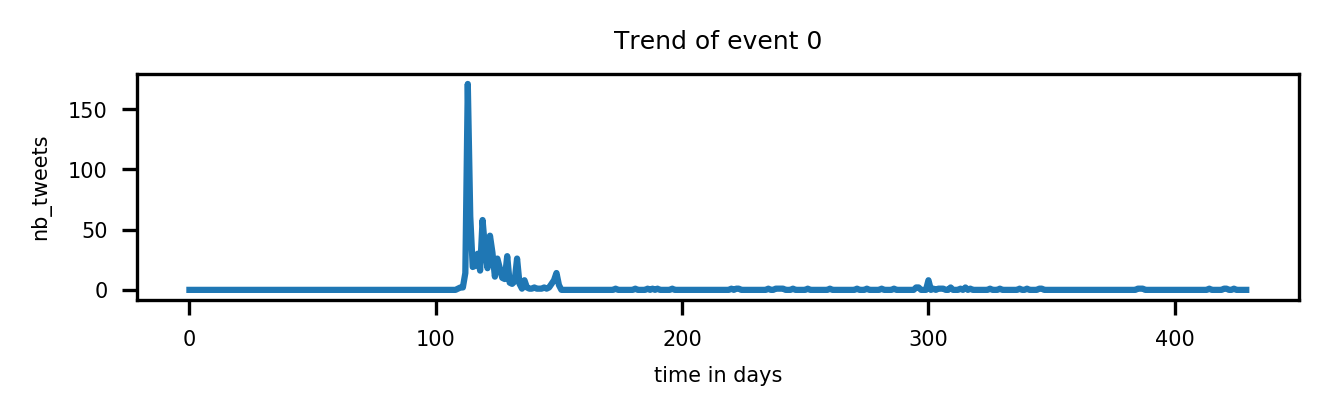



 event_id=129 - topic_id=439 - peak_date=2020-11-01 
['#happyhalloween' '#trickortreat' '#halloweenathome' '#trickortreating'
 '#spooktober' '#allhallowseve']


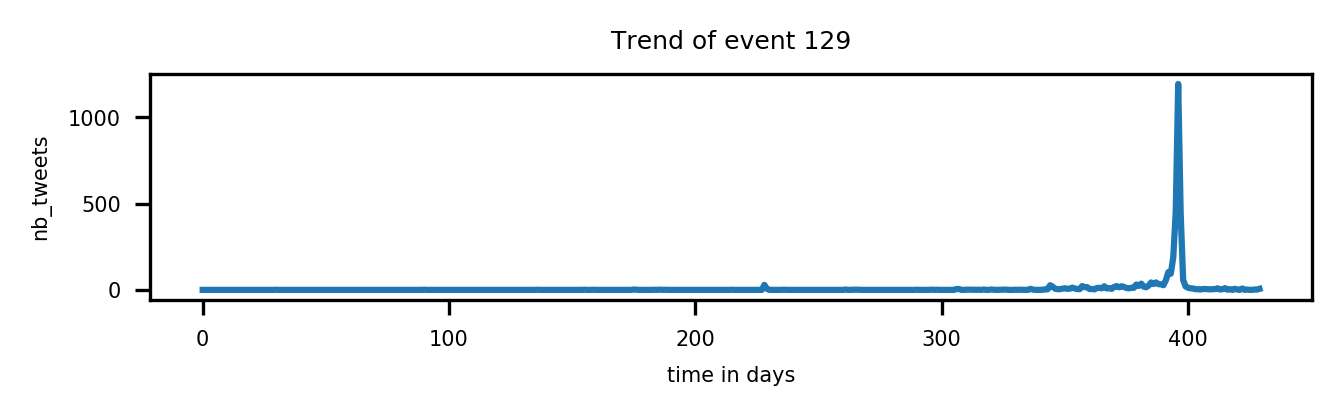



 event_id=38 - topic_id=735 - peak_date=2020-03-20 
['#burrmustresign' '#burrknew' '#loefflermustresign' '#burrresign'
 '#stockact' '#loefflerresign' '#burrbetrayedus']


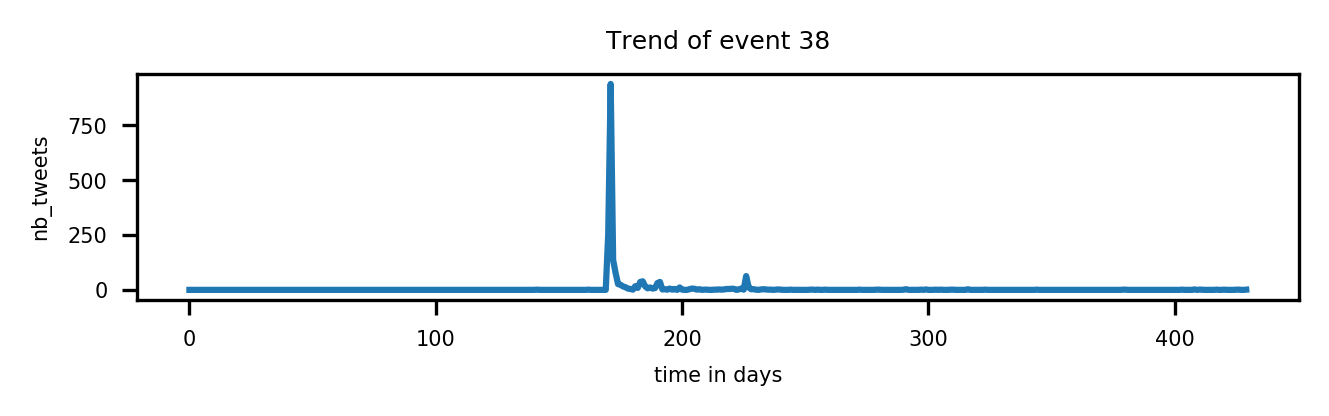



 event_id=67 - topic_id=598 - peak_date=2020-05-30 
['#mhday2020' '#itstimeforaction' '#periodsinpandemics' '#menstruation'
 '#menstrualhygiene' '#periods']


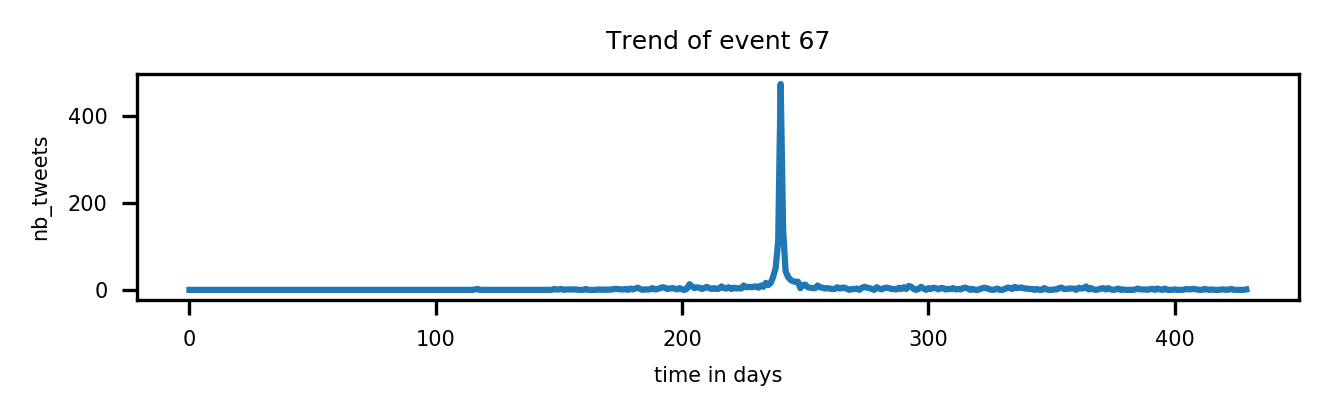



 event_id=93 - topic_id=6 - peak_date=2020-07-05 
['#fearwomen' '#bbnaijareunion' '#karachirain' '#joan'
 '#bbnaijareunion2020' '#bbnpepperdemreunion' '#joankubai'
 '#الطاعون_الدملي']


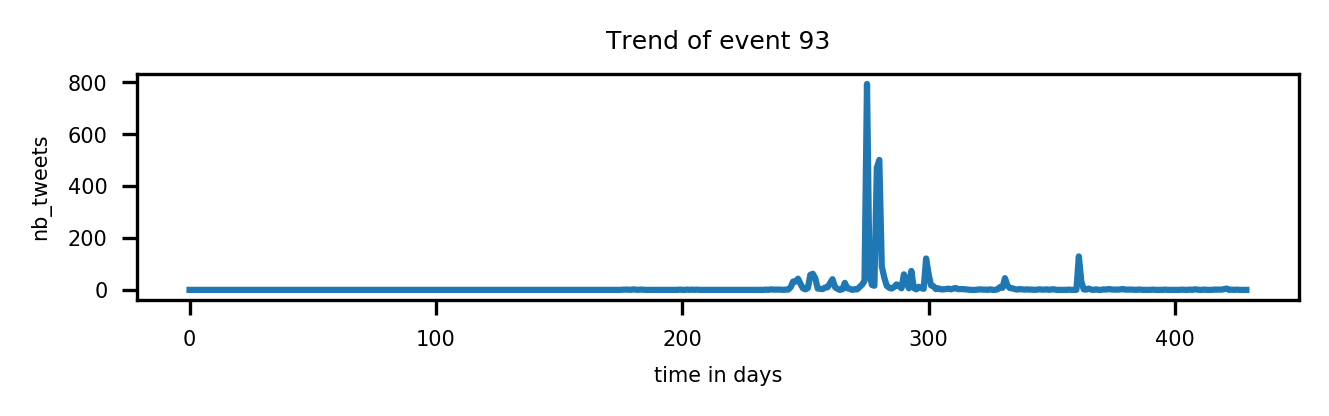



 event_id=6 - topic_id=733 - peak_date=2020-01-29 
['#슈퍼주니어' '#superjunior_2ya2yao' '#elf' '#heechul'
 '#15thanniv_walktogether' '#eunhyuk' '#2ya2yao' '#달려온15주년_손잡고걸을까']


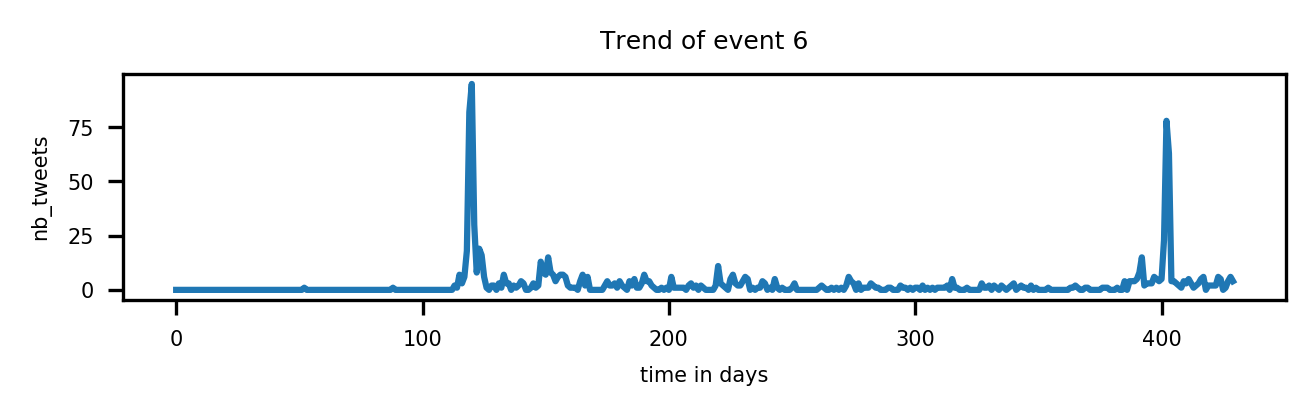



 event_id=66 - topic_id=289 - peak_date=2020-05-27 
['#brightwinqna' '#ripอ' '#ประช' '#monstax_fantasia' '#การบ'
 '#ขอ50ฟอลเทรนทนต' '#รรปสดช' '#savesaisawat' '#mixxiw' '#ออฟจ' '#ripจ'
 '#100kflukenatube' '#cuandoandodefiesta' '#aceyuyanday' '#bangbangpopup'
 '#got730dayschallenge']


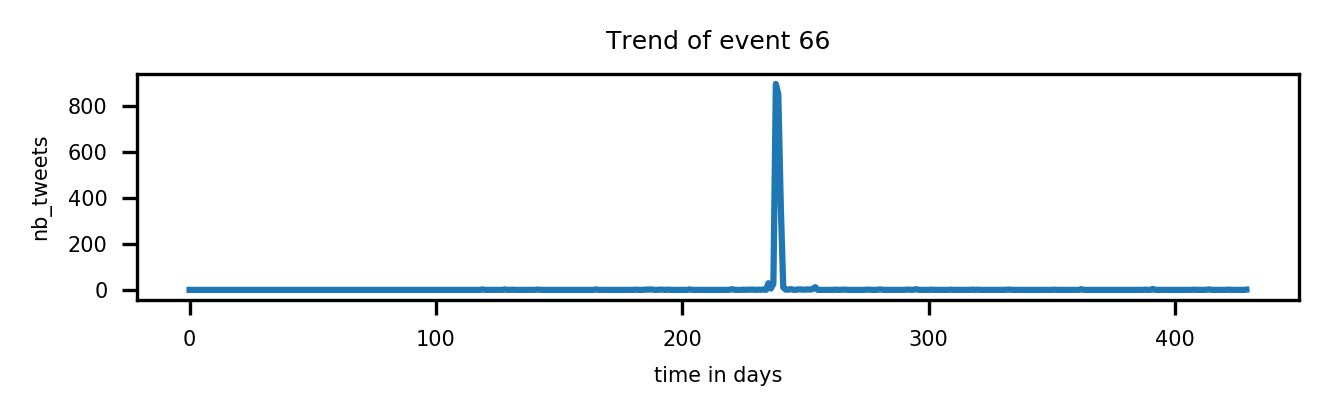



 event_id=76 - topic_id=801 - peak_date=2020-06-08 
['#postpone_aiims11june' '#postpone_aiims_11june' '#postponeaiimspg'
 '#postpone_midyear_exams' '#postpone_aiims_11jun' '#savedoctors11june']


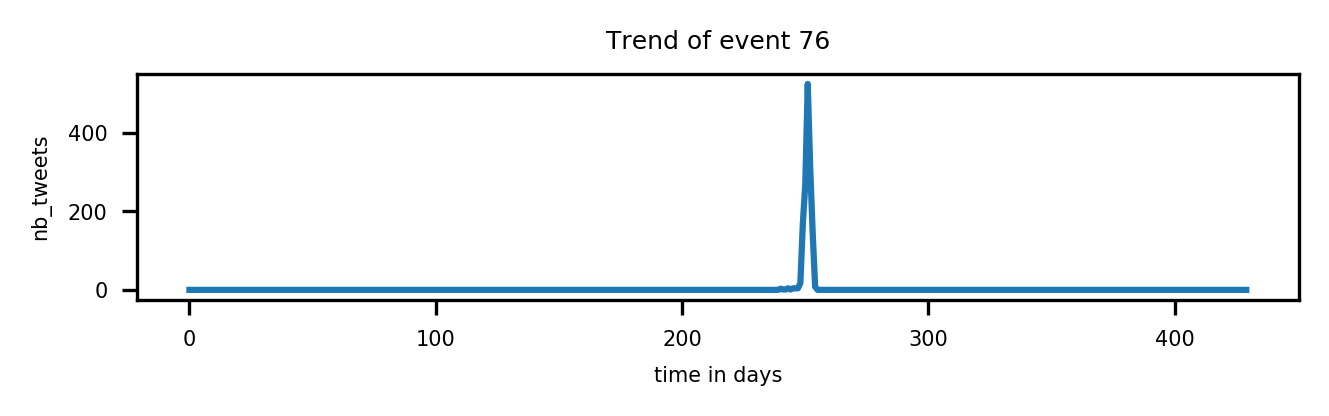

In [30]:
event_indices = np.random.choice(range(len(events)), replace=False, size=10)
plt.rcParams.update({'font.size': 5})
for e in event_indices :
    topic_id, day_nb, peak_date = events[e]
    print(f'\n\n event_id={e} - topic_id={topic_id} - peak_date={peak_date} ')
    print(topics[0][int(topic_id)])
    plt.figure(figsize=(5, 1))
    plt.plot(trends[0][topic_id])
    plt.ylabel('nb_tweets')
    plt.xlabel('time in days')
    plt.title(f'Trend of event {e}')
    plt.show()

There are almost no false positive but the assumption that there is only one large peak is sometimes wrong.

In [31]:
for i, e in enumerate(events) :
    topic_id, day_nb, peak_date = e
    
    if (i == 0) or (peak_date != events[i-1][2]):
        print('\n\n' + peak_date)
    
    print(topics[0][int(topic_id)])



2020-01-24
['#avionpresidencial' '#coronacapitalgdl' '#redamlo'
 '#paronacional24feb2020' '#preolimpico2020' '#redunidossomosuntsunami'
 '#lopezelcancerdemexico']


2020-01-26
['#felizjueves' '#felizmartes' '#felizsabado' '#felizviernesatodos'
 '#buenosdiasatodos' '#ripmamba' '#buenviernes' '#felizviernes' '#edomex'
 '#bienvenidos13' '#buensabado' '#royalrumble' '#grammyawards2020'
 '#domingodeganarseguidores' '#ucv' '#sanvalentin' '#los80' '#sabado'
 '#felizsanvalentin']
['#somosfortalezaydedicación' '#21añosderevoluciónvictoriosa'
 '#independenciaypaz' '#patriarebelde' '#antiimperialistasenmarcha'
 '#rumboalcrecimientoproductivo' '#aperturajudicialtsj2020'
 '#balancecarnavales2020' '#nomásimperios' '#escudobolivariano2020'
 '#nuestrafuerzaeslapaz' '#pueblosunidosporlapaz' '#trumplaamenazaerestú'
 '#endefensadelapaz' '#maximaprotecciónalpueblo' '#endefensadelapatria']
['#coronaviruschina' '#coronarvirus' '#coronarovirus' '#coronoavirus'
 '#coronaviruswuhan' '#coronavius' '#coronariv

We seen that we do not detect event in the strictest sense (e.g. '#coronavirusitalia') but it is still interesting to see why topics peak at certain dates. Moreover, using the timeline, we detect actual events like the SpaceX launch (2020-02-16), haloween (a bit shifted, 2020-11-01) and the Lekki genocide (2020-10-21).